In [176]:
from sklearn.datasets import make_circles
n_samples = 1000
X, y = make_circles(n_samples, noise = 0.03, random_state = 42)

In [177]:
print(f"First 5 values of X feature are \n{X[:5]}")
print(f"First 5 values of y feature are \n{y[:5]}")

First 5 values of X feature are 
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 values of y feature are 
[1 1 1 1 0]


In [178]:
#Make the dataframe of the circle data
import pandas as pd
circles = pd.DataFrame({"X1":X[:, 0],
                       "X2":X[:, 1],
                       "label":y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [179]:
circles.label.value_counts()  #to see how many instances have th label 1 or 0

label
1    500
0    500
Name: count, dtype: int64

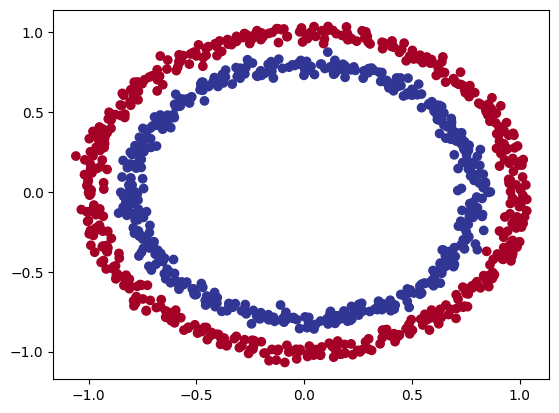

In [180]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu);

In [181]:
X.shape, y.shape

((1000, 2), (1000,))

## Turn data into tensors and create train and test splits

In [182]:
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [183]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size=0.2, random_state=42)

len(Xtrain), len(Ytrain), len(Xtest), len(Ytest)

(800, 800, 200, 200)

## Building a Model

In [184]:
from torch import nn
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [185]:
import torch

print("PyTorch version:", torch.__version__)
print("CUDA is available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("Number of GPUs available:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("GPU Type:", torch.cuda.get_device_name(0))


PyTorch version: 2.2.1+cu121
CUDA is available: False
CUDA version: 12.1
Number of GPUs available: 0


In [186]:
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features = 2, out_features = 5) #takes in 2 features and upscales to 5 features
    self.layer_2 = nn.Linear(in_features = 5, out_features = 1 ) #takes in 5 features ad outputs a single feature

  def forward(self, x):
    return self.layer_2(self.layer_1(x)) #x -> layer_1 -> layer_2 -> output


In [187]:
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [188]:
device

'cpu'

In [189]:
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [190]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0829, -0.2872],
                      [ 0.4691, -0.5582],
                      [-0.3260, -0.1997],
                      [-0.4252,  0.0667],
                      [-0.6984,  0.6386]])),
             ('0.bias', tensor([-0.6007,  0.5459,  0.1177, -0.2296,  0.4370])),
             ('1.weight',
              tensor([[ 0.0697,  0.3613,  0.0489, -0.1410,  0.1202]])),
             ('1.bias', tensor([-0.1213]))])

In [191]:
with torch.inference_mode():
  untrained_pred = model_0(Xtest.to(device))

In [192]:
len(untrained_pred), untrained_pred.shape

(200, torch.Size([200, 1]))

In [193]:
loss_fn = nn.BCEWithLogitsLoss() #sigmoid activation built in cross entropy loss function

In [194]:
optimizer = torch.optim.SGD(params=model_0.parameters(), lr = 0.01)

In [195]:
def accuracy(Ytest, Ypred):
  correct = torch.eq(Ytest, Ypred).sum().item()  # torch.eq() calculates where two tensors are equal
  acc = (correct/len(Ypred))*100
  return acc

### Train *Model*

In [196]:
y_logits = model_0(Xtest.to(device))
y_logits[:5]

tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967]], grad_fn=<SliceBackward0>)

In [197]:
y_pred_prob = torch.sigmoid(y_logits)
y_pred_prob[:5]

tensor([[0.4916],
        [0.4923],
        [0.5223],
        [0.4827],
        [0.5736]], grad_fn=<SliceBackward0>)

In [198]:
y_pred = torch.round(y_pred_prob)

In [199]:
y_pred = y_pred[:5]

In [200]:
y_pred_labels = torch.round(torch.sigmoid(model_0(Xtest.to(device))[:5]))
print(torch.eq(y_pred.squeeze(), y_pred_labels.squeeze()))


tensor([True, True, True, True, True])


# Building a training and testing loop

In [201]:
torch.manual_seed(42)

epochs = 100

Xtrain, Ytrain = Xtrain.to(device), Ytrain.to(device)
Xtest, Ytest = Xtest.to(device), Ytest.to(device)

for epoch in range(epochs):
  model_0.train()

  #1. Forward Pass
  yLogits = model_0(Xtrain).squeeze()
  y_pred = torch.round(torch.sigmoid(yLogits))
  loss = loss_fn(y_pred, Ytrain)
  acc = accuracy(Ytrain,  y_pred)
  optimizer.zero_grad()
  loss.backward()
  model_0.eval()
  with torch.inference_mode():
    test_logits = model_0(Xtest).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_pred, Ytest)
    test_acc = accuracy(Ytest, test_pred)
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.77251, Accuracy: 51.88% | Test loss: 0.74393, Test acc: 57.50%
Epoch: 10 | Loss: 0.77251, Accuracy: 51.88% | Test loss: 0.74393, Test acc: 57.50%
Epoch: 20 | Loss: 0.77251, Accuracy: 51.88% | Test loss: 0.74393, Test acc: 57.50%
Epoch: 30 | Loss: 0.77251, Accuracy: 51.88% | Test loss: 0.74393, Test acc: 57.50%
Epoch: 40 | Loss: 0.77251, Accuracy: 51.88% | Test loss: 0.74393, Test acc: 57.50%
Epoch: 50 | Loss: 0.77251, Accuracy: 51.88% | Test loss: 0.74393, Test acc: 57.50%
Epoch: 60 | Loss: 0.77251, Accuracy: 51.88% | Test loss: 0.74393, Test acc: 57.50%
Epoch: 70 | Loss: 0.77251, Accuracy: 51.88% | Test loss: 0.74393, Test acc: 57.50%
Epoch: 80 | Loss: 0.77251, Accuracy: 51.88% | Test loss: 0.74393, Test acc: 57.50%
Epoch: 90 | Loss: 0.77251, Accuracy: 51.88% | Test loss: 0.74393, Test acc: 57.50%


# Make predictions and evaluate the model


In [202]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, Xtrain, Ytrain)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, Xtest, Ytest)

# Improving a model (from a model perspective)

In [ ]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(in_features = 2, out_features = 10),
    self.layer2 = nn.Linear(in_features = 10, out_features = 10),
    self.layer3 = nn.Linear(in_features = 10, out_features = 1)
  def forward(self, x):
    return self.layer3(self.layer2(self.layer1(x)))

model_1 = CircleModelV1().to(device)
model_1


In [ ]:
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
print(model_3)

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(), lr=0.01)

In [ ]:
torch.manual_seed(42)
epochs = 1000

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_3(Xtrain).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, Ytrain) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy(Ytrain, y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_3(Xtest).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calcuate loss and accuracy
      test_loss = loss_fn(test_logits, Ytest)
      test_acc = accuracy(Ytest, test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

In [ ]:
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(Xtest))).squeeze()
y_preds[:10], y[:10] # want preds in same format as truth labels

In [ ]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.title("Test")
plot_decision_boundary(model_3, Xtest, Ytest) # model_3 = has non-linearity

# Replicating non-linear activation functions

In [ ]:
A = torch.arange(-10, 10, 1, dtype = torch.float32)
A

In [211]:
def relu(A):
  return torch.maximum(torch.tensor(0), A)
relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

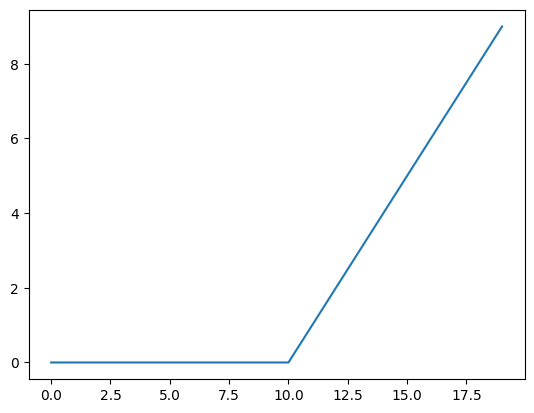

In [212]:
plt.plot(relu(A))

In [213]:
def sigmoid(A):
  z = 1/(1+torch.exp(-A))
  return z
sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

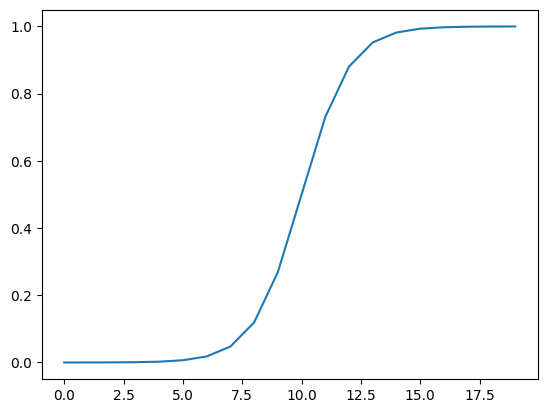

In [214]:
plt.plot(sigmoid(A))

# Putting things together by building a multi-class PyTorch model

In [215]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [216]:
#setting the hyperparameters for data creation
num_features = 2
num_classes = 4
random_seed = 42

#create multi-class data
X_blob, y_blob = make_blobs(n_samples = 1000,
                            n_features = num_features,
                            centers = num_classes,
                            cluster_std = 1.5,
                            random_state = random_seed)

In [217]:
X_blob = torch.from_numpy(X_blob).type(torch.float32)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

In [218]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X_blob, y_blob, test_size = 0.2, random_state = 42)

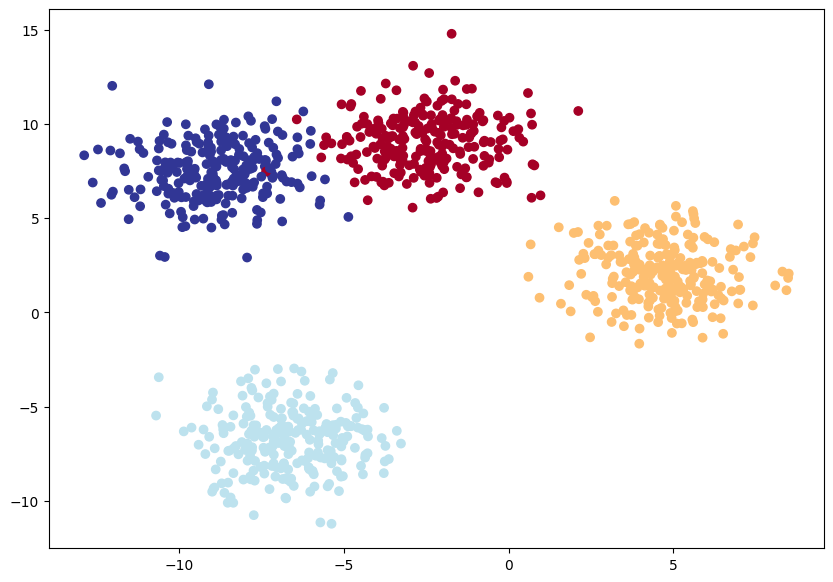

In [219]:
# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

# Building a multi-class classification model in PyTorch

In [220]:
class BlobModel(nn.Module):
  def __init__(self, inp_features, opt_features, hid_units):
    super().__init__()
    self.linear_layers = nn.Sequential(
        nn.Linear(in_features = inp_features, out_features = hid_units),
        nn.Linear(in_features = hid_units, out_features = hid_units),
        nn.Linear(in_features = hid_units, out_features = opt_features)
    )
  def forward(self, x):
    return self.linear_layers(x)

model_4 = BlobModel(inp_features = num_features, opt_features = num_classes, hid_units = 8).to(device)
model_4

BlobModel(
  (linear_layers): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

# Creating a loss function and optimizer for a multi-class PyTorch model

In [227]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_4.parameters(), lr = 0.1)

In [228]:
# Make prediction logits with model
y_logits = model_4(Xtest.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_preds = torch.softmax(y_logits,dim=1)
print(y_logits[:5])
print(y_preds[:5])

tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
        [ 1.7168, -1.2270,  1.7367,  2.1010],
        [ 2.2400,  0.7714,  2.6020,  1.0107],
        [-0.7993, -0.3723, -0.9138, -0.5388],
        [-0.4332, -1.6117, -0.6891,  0.6852]], grad_fn=<SliceBackward0>)
tensor([[0.1872, 0.2918, 0.1495, 0.3715],
        [0.2824, 0.0149, 0.2881, 0.4147],
        [0.3380, 0.0778, 0.4854, 0.0989],
        [0.2118, 0.3246, 0.1889, 0.2748],
        [0.1945, 0.0598, 0.1506, 0.5951]], grad_fn=<SliceBackward0>)


In [229]:
torch.sum(y_preds[0])

tensor(1., grad_fn=<SumBackward0>)

In [230]:
# Which class does the model think is *most* likely at the index 0 sample?
print(y_preds[0])
print(torch.argmax(y_pred[0]))

tensor([0.1872, 0.2918, 0.1495, 0.3715], grad_fn=<SelectBackward0>)
tensor(0)


# Creating a training and testing loop for a multi-class PyTorch model

In [236]:
epochs = 1000
torch.manual_seed(42)
Xtrain = Xtrain.to(device)
Ytrain = Ytrain.to(device)
Xtest = Xtest.to(device)
Ytest = Ytest.to(device)

for epoch in range(epochs):
  model_4.train()
  y_logits = model_4(Xtrain)
  y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = loss_fn(y_logits, Ytrain)
  acc = accuracy(Ytrain, y_preds)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  model_4.eval()

  with torch.inference_mode():
    test_logits = model_4(Xtest)
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)
    test_loss = loss_fn(test_logits, Ytest)
    test_acc = accuracy(Ytest, test_preds)

  if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.02302, Acc: 99.38% | Test Loss: 0.01133, Test Acc: 99.50%
Epoch: 10 | Loss: 0.02299, Acc: 99.38% | Test Loss: 0.01130, Test Acc: 99.50%
Epoch: 20 | Loss: 0.02297, Acc: 99.38% | Test Loss: 0.01128, Test Acc: 99.50%
Epoch: 30 | Loss: 0.02295, Acc: 99.38% | Test Loss: 0.01125, Test Acc: 99.50%
Epoch: 40 | Loss: 0.02293, Acc: 99.38% | Test Loss: 0.01123, Test Acc: 99.50%
Epoch: 50 | Loss: 0.02291, Acc: 99.38% | Test Loss: 0.01121, Test Acc: 99.50%
Epoch: 60 | Loss: 0.02289, Acc: 99.38% | Test Loss: 0.01118, Test Acc: 99.50%
Epoch: 70 | Loss: 0.02287, Acc: 99.38% | Test Loss: 0.01116, Test Acc: 99.50%
Epoch: 80 | Loss: 0.02285, Acc: 99.38% | Test Loss: 0.01114, Test Acc: 99.50%
Epoch: 90 | Loss: 0.02282, Acc: 99.38% | Test Loss: 0.01111, Test Acc: 99.50%
Epoch: 100 | Loss: 0.02280, Acc: 99.38% | Test Loss: 0.01109, Test Acc: 99.50%
Epoch: 110 | Loss: 0.02278, Acc: 99.38% | Test Loss: 0.01107, Test Acc: 99.50%
Epoch: 120 | Loss: 0.02276, Acc: 99.38% | Test Loss: 0.01104, T

In [232]:
y_logits.shape, Ytrain.shape

(torch.Size([800, 4]), torch.Size([800]))

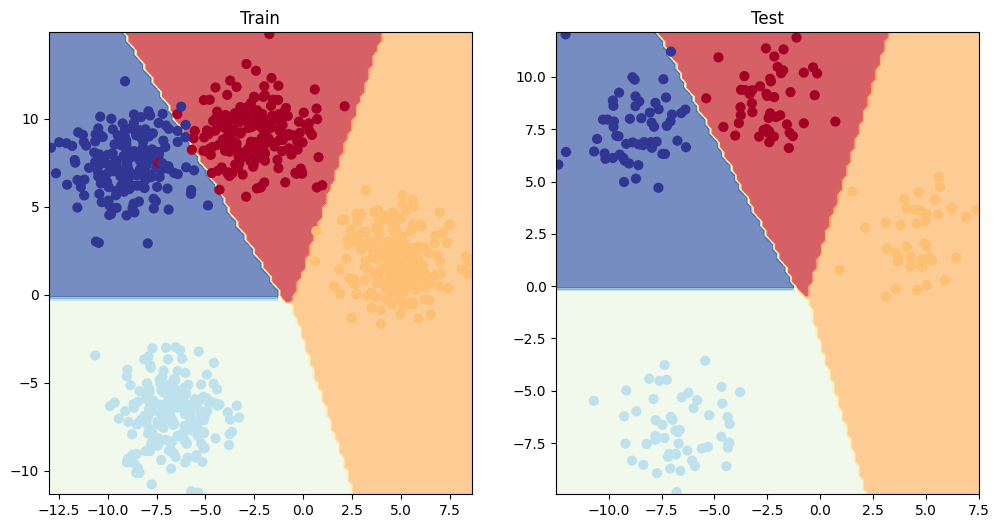

In [238]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, Xtrain, Ytrain)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, Xtest, Ytest)

# More classification evaluation metrics

In [240]:
try:
    from torchmetrics import Accuracy
except:
    !pip install torchmetrics==0.9.3 # this is the version we're using in this notebook (later versions exist here: https://torchmetrics.readthedocs.io/en/stable/generated/CHANGELOG.html#changelog)
    from torchmetrics import Accuracy

# Setup metric and make sure it's on the target device
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

# Calculate accuracy
torchmetrics_accuracy(test_preds, Ytest)

tensor(0.9950)